In [1]:
# %cd ..
import numpy as np, matplotlib.pyplot as plt, os
import inputs, simuls, analysis
results = analysis.GetResults(verbose=True)

In [2]:
program_folder = "PHITS_xyz"
border = "Water-Lung"
folder = f"RESULTS/border/{border}/{program_folder}"
trim = int(1e6)

rthresh = {"F18" : 3, "Ga68" : 10}  #water
if border == "Water-Bone":
    rthresh = {"F18" : 3+10, "Ga68" : 10+10}
elif border== "Water-Lung":
    rthresh = {"F18" : 8+10, "Ga68" : 30+10}


for iso in rthresh.keys():
    if program_folder == "GATE7_xyz" and iso not in ["C11", "O15", "F18"]:
        continue
    print(f"Filtering {iso}")
    threshold = rthresh[iso] #mm
    analysis.filter_rmax(f"{folder}/{iso}.dat.original", f"{folder}/{iso}.dat", threshold=threshold, trim=trim, fmt='%.10f')

Filtering F18
Filtered 'RESULTS/border/Water-Lung/PHITS_xyz/F18.dat.original' to 'RESULTS/border/Water-Lung/PHITS_xyz/F18.dat': 0 points removed
Filtering Ga68
Filtered 'RESULTS/border/Water-Lung/PHITS_xyz/Ga68.dat.original' to 'RESULTS/border/Water-Lung/PHITS_xyz/Ga68.dat': 4 points removed


In [2]:
histo_bins = 50
histo_step = .15 #cm
isotopes = ["F18", "Ga68"] 
pfolders = {
    "PHITS 3.3":"PHITS_xyz",
    "PenEasy 2020":"PenEasy2020_vox",
    # "PenEasy 2024":"PenEasy2024_xyz",
    # "PeneloPET 2024":"PeneloPET2024_xyz",
    "GATE 9.2":"GATE92_vox",
    # "GATE 9.3":"GATE93_xyz",
    # "GATE 7.0":"GATE7_xyz",
}

borders = ["Water-Lung", "Water-Bone"]

labels_iso = {iso:[] for iso in isotopes}
labels_prg = {p:[] for p in pfolders.keys()}
labels_brd = {b:[] for b in borders}

results.active_results.clear()
for border in borders:
    for iso in isotopes:
        for pname, pfolder in pfolders.items():
            if pfolder == "GATE7_xyz" and iso not in ["C11", "O15", "F18"]: continue
            if pfolder != "PHITS_xyz" and iso not in ["Ga68"]: continue
            # file with results
            match pfolder[-3:]:
                case "xyz":
                    ext = "dat"
                case "vox":
                    ext = "raw"
                case _:
                    raise ValueError(f"Unknown folder extension: {pfolder}")
                
            rf = f"RESULTS/border/{border}/{pfolder}/{iso}.{ext}"
            # result label
            rl = f"{pname} {iso} {border}"

            # load results
            results.load(rl, rf, 
                         [histo_bins + (1 if 'vox' in pfolder else 0)]*3, 
                         [histo_step]*3)
            if pname == "PHITS 3.3":
                results.active_results[rl].aPSFx_range *= -1 
            elif pname in ["PenEasy 2020", "GATE 9.2"]:
                results.active_results[rl].aPSFx_range += histo_step/2

            # append label to labels
            labels_iso[iso].append(rl)
            labels_prg[pname].append(rl)
            labels_brd[border].append(rl)

PHITS 3.3 F18 Water-Lung loaded
PHITS 3.3 Ga68 Water-Lung loaded
PenEasy 2020 Ga68 Water-Lung loaded
GATE 9.2 Ga68 Water-Lung loaded
PHITS 3.3 F18 Water-Bone loaded
PHITS 3.3 Ga68 Water-Bone loaded
PenEasy 2020 Ga68 Water-Bone loaded
GATE 9.2 Ga68 Water-Bone loaded


In [3]:
results.data_analysis()

Size of annihilations sample:
     PHITS 3.3 F18 Water-Lung                	   1000000
     PHITS 3.3 Ga68 Water-Lung               	   1000000
     PenEasy 2020 Ga68 Water-Lung            	   9999908
     GATE 9.2 Ga68 Water-Lung                	   8892314
     PHITS 3.3 F18 Water-Bone                	   1000000
     PHITS 3.3 Ga68 Water-Bone               	   1000000
     PenEasy 2020 Ga68 Water-Bone            	   9999908
     GATE 9.2 Ga68 Water-Bone                	   8891961
Number of annihilation point coords:
     PHITS 3.3 F18 Water-Lung                	   1000000
     PHITS 3.3 Ga68 Water-Lung               	   1000000
     PenEasy 2020 Ga68 Water-Lung            	     13185
     GATE 9.2 Ga68 Water-Lung                	     11496
     PHITS 3.3 F18 Water-Bone                	   1000000
     PHITS 3.3 Ga68 Water-Bone               	   1000000
     PenEasy 2020 Ga68 Water-Bone            	      4958
     GATE 9.2 Ga68 Water-Bone                	      4668
Maximum radial distan

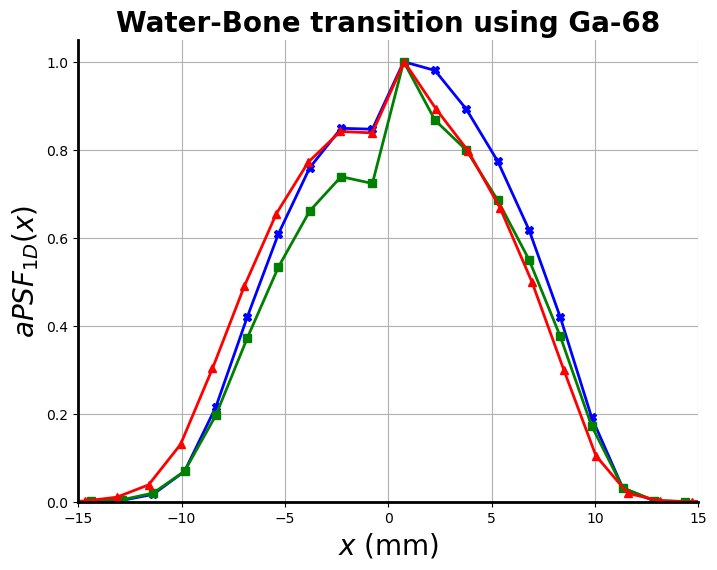

In [7]:
border = "Water-Bone"
iso = "Ga68"
symbols = {'PenEasy 2020': 'gs', 'GATE 9.2': 'bX', 'PHITS 3.3': 'r^'}
l1 = set(labels_iso[iso])
l2 = set(labels_brd[border])
l = list(l1.intersection(l2))
sl = list(pfolders.keys())
if iso != "Ga68":
    sl.remove("PenEasy 2020")
    sl.remove("GATE 9.2")
# Ensure each value in sl is contained inside its corresponding key
sl = {key:value for key in l for value in sl if value in key}
plt.figure(figsize=(8,6))
for l, sl in sl.items():
    img = results.active_results[l].img
    aPSFx = np.sum(img, axis=(1,2))
    aPSFx /= aPSFx.max()
    aPSFx_range = np.linspace(-histo_bins*histo_step/2, (histo_bins+1)*histo_step/2, histo_bins + (1 if 'PHITS' not in l else 0))
    aPSFx_range += histo_step/4
    if "PHITS" in l:
        aPSFx = aPSFx[::-1]
        aPSFx_range -= histo_step/2
    aPSFx_range *= 10  #cm to mm

    plt.plot(aPSFx_range, aPSFx, symbols[sl]+'-', label=sl)


plt.xlabel(r"$x$ (mm)")
plt.ylabel(r"$aPSF_{1D}(x)$")
plt.title(f"{border} transition using {analysis.iso_in_plots(iso)}")
plt.xlim(-15, 15)
ax, leg = analysis.aesthetic_plot()
leg.set_visible(False)
plt.show()